In [52]:
import os
import json
import chardet
import torch
import torch.nn as nn
from torch.optim import AdamW
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader,TensorDataset
from torch.utils.data import ConcatDataset, DataLoader
from Config import config
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import numpy as np
from torchvision import transforms
from transformers import AutoTokenizer
from transformers import AutoModel
from torchvision.models import resnet50
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


### 模型储存-->划分训练测试集-->文本处理-->图像处理-->计算均值和方差

In [ ]:
# 模型储存
def save_model(output_path, model_type, model):
    output_model_dir = os.path.join(output_path, model_type)
    if not os.path.exists(output_model_dir): os.makedirs(output_model_dir)    # 没有文件夹则创建
    model_to_save = model.module if hasattr(model, 'module') else model     # Only save the model it-self
    output_model_file = os.path.join(output_model_dir, "pytorch_model.bin")
    torch.save(model_to_save.state_dict(), output_model_file)
# 划分训练集测试集
def train_val_split(data, val_size=0.2):
    return train_test_split(data, train_size=(1-val_size), test_size=val_size)
# 文本处理
def text_process(input_path, data_dir, output_path):
    data = []
    with open(input_path) as f:
        for line in tqdm(f.readlines(), desc='[Formating txt file]'):
            guid, label = line.replace('\n', '').split(',')
            text_path = os.path.join(data_dir, (guid + '.txt'))
            if guid == 'guid': continue
            with open(text_path, 'rb') as textf:
                text_byte = textf.read()
                encode = chardet.detect(text_byte)
                try:
                    text = text_byte.decode(encode['encoding'])
                except:
                    # print('can\'t decode file', guid)
                    try:
                        text = text_byte.decode('iso-8859-1').encode('iso-8859-1').decode('gbk')
                    except:
                        print('not is0-8859-1', guid)
                        continue
            text = text.strip('\n')
            text=text.strip('\r')
            text=text.strip(' ')
            text=text.strip()
            data.append({ 'guid': guid,'label': label,'text': text})
    current_directory = os.getcwd()
    #print("当前工作目录:", current_directory)
    with open(output_path, 'w') as wf:
        json.dump(data, wf, indent=4)

# 读取数据，返回[(guid, text, img, label)]元组列表
def image_process(path, data_dir):
    data = []
    with open(path) as f:
        json_file = json.load(f)
        for d in tqdm(json_file, desc='[Loading image file]'):
            guid, label, text = d['guid'], d['label'], d['text']
            if guid == 'guid': continue
            img_path = os.path.join(data_dir, (guid + '.jpg'))
            # img = cv2.imread(img_path)
            img = Image.open(img_path)
            img.load()
            data.append((guid, text, img, label))
        f.close()

    return data
# 计算图片均值
def calculate_mean_std(json_file_path, image_root_dir):
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    #print(data[0]['guid'])
    num_images = len(data)
    channel_means = [0.0, 0.0, 0.0]
    channel_stds = [0.0, 0.0, 0.0]
    for i in range(num_images):
        image_path = f"{image_root_dir}/{data[i]['guid']}.jpg"
        img = np.array(Image.open(image_path))
        img = img.astype(np.float32) / 255.0
        for i in range(3): 
            channel_means[i] += np.mean(img[:, :, i])
            channel_stds[i] += np.std(img[:, :, i])

    overall_mean = np.array(channel_means) / num_images
    overall_std = np.array(channel_stds) / num_images

    return overall_mean, overall_std


In [92]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


### 定义数据处理的情绪词典和数据处理器

In [55]:
from dataset import MyDataset
from encoder import encode
from decoder import final_output

# 用于转换数字标签和情绪单词
class LabelVocab:
    UNK='UNK'

    def __init__(self):
        self.labeltoid={}
        self.idtolabel={}
    
    def __len__(self):
        return len(self.labeltoid)
    
    def add_label(self,label):
        if label not in  self.labeltoid:
            self.labeltoid.update({label:len(self.labeltoid)})
            self.idtolabel.update({len(self.idtolabel):label})

    def label_to_id(self,label):
        return self.labeltoid.get(label)
    
    def id_to_label(self,id):
        return self.idtolabel.get(id)
# 采取外置的python文件
class Data_processor:
    def __init__(self,config):
        self.config=config
        self.labelvocab=LabelVocab()
        pass
    def __call__(self,data,params):
        return self.to_loader(data,params)

    def encoder(self,data_json):
        return encode(data_json,self.labelvocab,self.config)
    
    def decode(self,outputs):
        return final_output(outputs,self.labelvocab)
    
    def todataset(self,data_json):
        input=self.encoder(data_json)
        return MyDataset(*input)
    
    def to_loader(self,data_json,params):
        dataset=self.todataset(data_json)
        return DataLoader(dataset=dataset,**params,collate_fn=dataset.mask_and_pad)


### 模型搭建

In [58]:
class Text_Sentimental(nn.Module):
    def __init__(self,config):
        super(Text_Sentimental,self).__init__()

        self.bert=AutoModel.from_pretrained(config.bert_name)
        
        dropout_rate=config.bert_dropout
        input_size=self.bert.config.hidden_size
        output_size=config.middle_hidden_size
      
        self.transform=nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(input_size,output_size),
            nn.ReLU(inplace=True)
        )
    
    def forward(self,inputs,masks,token_type_ids=None):
        #print("T forward")
        outputs=self.bert(input_ids=inputs,token_type_ids=token_type_ids,attention_mask=masks)
        hidden_state=outputs['last_hidden_state']
        pooler_out=outputs['pooler_output']

        return self.transform(hidden_state),self.transform(pooler_out)
    

class Img_Sentimental(nn.Module):

    def __init__(self,config):
        super(Img_Sentimental,self).__init__()
        self.resnet=resnet50(pretrained=True)

        self.resnet_hidden=nn.Sequential(
            *(list(self.resnet.children())[:-2])
        )

        self.resnet_factor=nn.Sequential(
            list(self.resnet.children())[-2],
            nn.Flatten()
        )
        

        self.hidden_transform = nn.Sequential(
            nn.Conv2d(self.resnet.fc.in_features, config.img_hidden_seq, 1),
            nn.Flatten(start_dim=2),
            nn.Dropout(config.resnet_dropout),
            #  nn.Linear(3*3, config.middle_hidden_size),
            #nn.Linear(5*5, config.middle_hidden_size),  
            nn.Linear(7*7, config.middle_hidden_size),
            nn.ReLU(inplace=True)
        )

        
        dropout_rate=config.resnet_dropout
        input_size=self.resnet.fc.in_features
        output_size=config.middle_hidden_size
        
        self.transform=nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(input_size,output_size ),
            nn.ReLU(inplace=True)
        )


    def forward(self, imgs):
        #print("I forward")
        hidden_state = self.resnet_hidden(imgs)
        feature = self.resnet_factor(hidden_state)
        return self.hidden_transform(hidden_state), self.transform(feature)
    

class Multi_Sentimental(nn.Module):

    def __init__(self,config):
        super(Multi_Sentimental,self).__init__()
        
        #embed=config.middle_hidden_size[0],
        #num_heads=config.attention_nhead,
        #dropout_rate_attention=config.attention_dropout,
        #dropout_rate_fuse=config.fuse_dropout,
        #output_size=config.out_hidden_size,
        #num_labels=config.num_labels

        self.Text_model = Text_Sentimental(config)
        self.Image_model = Img_Sentimental(config)


        self.text_img_attention = nn.MultiheadAttention(
            embed_dim=config.middle_hidden_size,
            num_heads=config.attention_nhead, 
            dropout=config.attention_dropout,
        )
        self.img_text_attention = nn.MultiheadAttention(
            embed_dim=config.middle_hidden_size,
            num_heads=config.attention_nhead, 
            dropout=config.attention_dropout
        )

        self.text_ = nn.Sequential(
            nn.Dropout(config.fuse_dropout),
            nn.Linear(2*config.middle_hidden_size, config.out_hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(config.fuse_dropout),
            nn.Linear(config.out_hidden_size,config.num_labels),
            nn.Softmax(dim=1)
        )

        self.img_ = nn.Sequential(
            nn.Dropout(config.fuse_dropout),
            nn.Linear(2* config.middle_hidden_size, config.out_hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(config.fuse_dropout),
            nn.Linear(config.out_hidden_size,config.num_labels),
            nn.Softmax(dim=1)
        )

        self.loss_func = nn.CrossEntropyLoss()

    def forward(self, texts, texts_mask, imgs, labels=None):
            #print("T+I forward")
            text_hidden_state, text_feature = self.Text_model(texts, texts_mask)
            text_hidden_state = text_hidden_state.permute(1, 0, 2)
            
            img_hidden_state, img_feature = self.Image_model(imgs)
            img_hidden_state = img_hidden_state.permute(1, 0, 2)

            text2img_attention_out, _ = self.img_text_attention(img_hidden_state,text_hidden_state, text_hidden_state)
            text2img_attention_out = torch.mean(text2img_attention_out, dim=0).squeeze(0)

            img2text_attention_out, _ = self.text_img_attention(text_hidden_state,img_hidden_state, img_hidden_state)
            img2text_attention_out = torch.mean(img2text_attention_out, dim=0).squeeze(0)

            text_probability = self.text_(torch.cat([text_feature,  img2text_attention_out], dim=1))
            img_probability = self.img_(torch.cat([img_feature, text2img_attention_out], dim=1))

            total_probability = torch.softmax((text_probability + img_probability), dim=1)
            pred_labels = torch.argmax(total_probability, dim=1)

            if labels is not None:
                loss = self.loss_func(total_probability, labels)
                return pred_labels, loss
            else:
                return pred_labels
        

### 根据具体情况求训练集的均值和方差

In [53]:
json_file_path = 'processed'
image_root_dir = 'data1'
mean, std = calculate_mean_std(json_file_path, image_root_dir)
print("Mean:", mean)
print("Std:", std)


Mean: [0.4965252  0.45888674 0.43725428]
Std: [0.25523951 0.24872537 0.2451266 ]


In [56]:
# 将文本和标签格式化成一个json
text_process('train.txt','data1','processed')
data_json=image_process('processed', 'data1')
train_data, val_data = train_val_split(data_json)


[Loading image file]: 100%|██████████| 4000/4000 [00:14<00:00, 284.67it/s]


In [57]:
# 处理训练集和验证集
processor = Data_processor(config)
train_loader = processor(train_data,config.train_params)
val_loader = processor(val_data,config.val_params)

it is encoding!:   1%|          | 26/3200 [00:00<00:28, 109.69it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:   2%|▏         | 63/3200 [00:00<00:20, 156.72it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:   3%|▎         | 92/3200 [00:00<00:15, 199.92it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:   5%|▍         | 150/3200 [00:00<00:12, 238.61it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:   7%|▋         | 209/3200 [00:00<00:11, 256.87it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:   8%|▊         | 270/3200 [00:01<00:10, 268.48it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  10%|█         | 323/3200 [00:01<00:11, 247.80it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  12%|█▏        | 373/3200 [00:01<00:11, 247.85it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  13%|█▎        | 404/3200 [00:01<00:10, 254.36it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  14%|█▍        | 456/3200 [00:01<00:10, 253.27it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  16%|█▌        | 509/3200 [00:02<00:10, 253.25it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  18%|█▊        | 561/3200 [00:02<00:10, 255.75it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  19%|█▉        | 615/3200 [00:02<00:10, 236.16it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  21%|██        | 665/3200 [00:02<00:10, 241.72it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  22%|██▏       | 716/3200 [00:03<00:10, 239.06it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  24%|██▍       | 766/3200 [00:03<00:10, 234.43it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  25%|██▍       | 790/3200 [00:03<00:10, 234.36it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  26%|██▌       | 837/3200 [00:03<00:10, 225.62it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  28%|██▊       | 884/3200 [00:03<00:10, 220.44it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  29%|██▉       | 933/3200 [00:03<00:09, 232.67it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  31%|███       | 983/3200 [00:04<00:09, 226.55it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  32%|███▏      | 1030/3200 [00:04<00:09, 220.56it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  34%|███▎      | 1079/3200 [00:04<00:09, 231.20it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  34%|███▍      | 1103/3200 [00:04<00:09, 215.60it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  36%|███▌      | 1145/3200 [00:05<00:12, 166.41it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  37%|███▋      | 1189/3200 [00:05<00:10, 186.24it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  38%|███▊      | 1209/3200 [00:05<00:11, 180.70it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  40%|███▉      | 1274/3200 [00:05<00:09, 203.96it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  40%|████      | 1295/3200 [00:05<00:09, 201.62it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  42%|████▏     | 1342/3200 [00:06<00:08, 217.32it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  44%|████▍     | 1402/3200 [00:06<00:07, 250.76it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  46%|████▌     | 1460/3200 [00:06<00:06, 265.82it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  48%|████▊     | 1522/3200 [00:06<00:06, 278.80it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  50%|████▉     | 1597/3200 [00:06<00:05, 302.88it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  52%|█████▏    | 1664/3200 [00:07<00:05, 275.19it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  53%|█████▎    | 1693/3200 [00:07<00:05, 268.29it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  55%|█████▍    | 1755/3200 [00:07<00:05, 270.49it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  57%|█████▋    | 1815/3200 [00:07<00:05, 273.22it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  58%|█████▊    | 1871/3200 [00:07<00:05, 258.46it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  60%|██████    | 1929/3200 [00:08<00:04, 269.17it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  62%|██████▏   | 1992/3200 [00:08<00:04, 281.68it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  64%|██████▍   | 2052/3200 [00:08<00:03, 289.59it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  66%|██████▌   | 2113/3200 [00:08<00:03, 285.42it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  67%|██████▋   | 2142/3200 [00:08<00:03, 273.09it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  69%|██████▉   | 2204/3200 [00:09<00:03, 278.24it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  70%|██████▉   | 2232/3200 [00:09<00:03, 267.46it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  71%|███████▏  | 2282/3200 [00:09<00:04, 207.08it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  73%|███████▎  | 2342/3200 [00:09<00:03, 246.00it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  75%|███████▍  | 2395/3200 [00:09<00:03, 251.25it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  77%|███████▋  | 2454/3200 [00:10<00:03, 247.12it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  78%|███████▊  | 2480/3200 [00:10<00:03, 212.22it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  78%|███████▊  | 2503/3200 [00:10<00:04, 163.38it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  79%|███████▉  | 2541/3200 [00:10<00:03, 166.59it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  81%|████████  | 2581/3200 [00:10<00:03, 178.43it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  82%|████████▏ | 2623/3200 [00:11<00:03, 175.92it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  84%|████████▎ | 2674/3200 [00:11<00:02, 210.39it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  84%|████████▍ | 2699/3200 [00:11<00:02, 218.63it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  86%|████████▌ | 2749/3200 [00:11<00:01, 228.38it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  87%|████████▋ | 2795/3200 [00:12<00:01, 208.06it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  89%|████████▉ | 2844/3200 [00:12<00:01, 219.52it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  91%|█████████ | 2899/3200 [00:12<00:01, 246.38it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  92%|█████████▎| 2960/3200 [00:12<00:00, 261.53it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  94%|█████████▍| 3018/3200 [00:12<00:00, 264.92it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  96%|█████████▋| 3081/3200 [00:13<00:00, 281.21it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  98%|█████████▊| 3138/3200 [00:13<00:00, 271.00it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!: 100%|██████████| 3200/3200 [00:13<00:00, 236.70it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!



it is encoding!:   7%|▋         | 59/800 [00:00<00:02, 289.19it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  12%|█▏        | 92/800 [00:00<00:02, 301.41it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  19%|█▉        | 154/800 [00:00<00:02, 295.32it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  30%|███       | 244/800 [00:00<00:01, 287.65it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  34%|███▍      | 273/800 [00:00<00:01, 284.95it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  42%|████▏     | 333/800 [00:01<00:01, 290.34it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  49%|████▉     | 395/800 [00:01<00:01, 283.29it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  56%|█████▋    | 451/800 [00:01<00:01, 259.65it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  60%|█████▉    | 478/800 [00:01<00:01, 252.08it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  66%|██████▌   | 527/800 [00:02<00:01, 209.53it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  71%|███████▏  | 570/800 [00:02<00:01, 202.76it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  76%|███████▋  | 611/800 [00:02<00:00, 193.77it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  79%|███████▉  | 633/800 [00:02<00:00, 197.96it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  82%|████████▏ | 653/800 [00:02<00:00, 149.18it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  84%|████████▍ | 670/800 [00:03<00:01, 116.19it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  87%|████████▋ | 697/800 [00:03<00:00, 110.33it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  91%|█████████ | 728/800 [00:03<00:00, 128.15it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  94%|█████████▍| 756/800 [00:03<00:00, 127.36it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  96%|█████████▋| 770/800 [00:03<00:00, 127.59it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!: 100%|██████████| 800/800 [00:04<00:00, 196.38it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


### 模型训练开始

In [59]:
from Config import config

model = Multi_Sentimental(config)

bert_params = set(model.Text_model.bert.parameters())
resnet_params = set(model.Image_model.resnet.parameters())
other_params = list(set(model.parameters()) - bert_params - resnet_params)
no_decay = ['bias', 'LayerNorm.weight']

common_params = {'weight_decay': config.weight_decay}


bert_params = [
    {'params': [p for n, p in model.Text_model.bert.named_parameters() if not any(nd in n for nd in no_decay)],
        'lr': config.bert_learning_rate, **common_params},
    {'params': [p for n, p in model.Text_model.bert.named_parameters() if any(nd in n for nd in no_decay)],
        'lr': config.bert_learning_rate, 'weight_decay': 0.0},
]

resnet_params = [
    {'params': [p for n, p in model.Image_model.resnet.named_parameters() if not any(nd in n for nd in no_decay)],
        'lr': config.resnet_learning_rate, **common_params},
    {'params': [p for n, p in model.Image_model.resnet.named_parameters() if any(nd in n for nd in no_decay)],
        'lr': config.resnet_learning_rate, 'weight_decay': 0.0},
]

other_params_group = [{'params': other_params, 'lr': config.learning_rate, **common_params}]

params = bert_params + resnet_params + other_params_group
print('TextModel: {}, ImageModel: {}, FuseModel: {}'.format(config.bert_name, 'ResNet50', config.fuse_model_type))
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\vip\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\vip\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TextModel: roberta-base, ImageModel: ResNet50, FuseModel: NaiveCombine


### 模型训练

----- [训练 Epoch 1/5] :   0%|          | 0/200 [00:00<?, ?it/s]

----- [训练 Epoch 1/5] : 100%|██████████| 200/200 [24:51<00:00,  7.46s/it]


Training Accuracy: 0.5625
Epoch [1/5], 平均训练损失: 0.9496


----- [训练 Epoch 2/5] : 100%|██████████| 200/200 [25:01<00:00,  7.51s/it]


Training Accuracy: 0.6875
Epoch [2/5], 平均训练损失: 0.8696


----- [训练 Epoch 3/5] : 100%|██████████| 200/200 [24:59<00:00,  7.50s/it]


Training Accuracy: 0.9375
Epoch [3/5], 平均训练损失: 0.8283


----- [训练 Epoch 4/5] : 100%|██████████| 200/200 [24:38<00:00,  7.39s/it]


Training Accuracy: 0.75
Epoch [4/5], 平均训练损失: 0.8082


----- [训练 Epoch 5/5] : 100%|██████████| 200/200 [24:55<00:00,  7.48s/it]


Training Accuracy: 1.0
Epoch [5/5], 平均训练损失: 0.7979


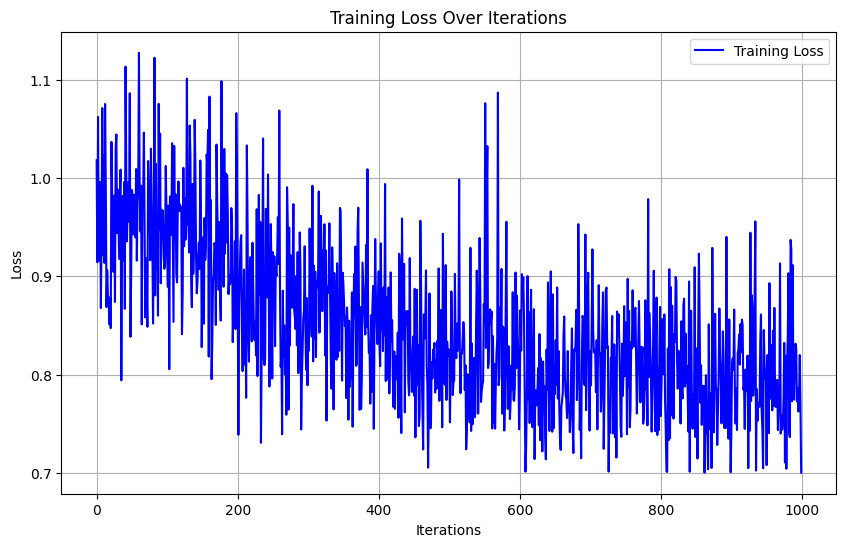

In [63]:
model.train()
optimizer = AdamW(params, lr=config.learning_rate)
loss_list = []
true_labels, pred_labels = [], []
num_epochs=5
loss_all_list=[]
for epoch in range(num_epochs):
    model.train()  
    loss_list = []  
    count=1
    for batch in tqdm(train_loader, desc=f'----- [训练 Epoch {epoch + 1}/{num_epochs}] '):
        #print(1)
        guids, texts, texts_mask, imgs, labels = batch
        #print(2)
        texts, texts_mask, imgs, labels = texts.to(device), texts_mask.to(device), imgs.to(device), labels.to(device)
        #print(3)
        pred, loss = model(texts, texts_mask, imgs, labels=labels)

        loss_list.append(loss.item())
        loss_all_list.append(loss.item())
        true_labels.extend(labels.tolist())
        pred_labels.extend(pred.tolist())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        correct_predictions = (pred == labels).sum().item()
        total_samples = labels.size(0)
        accuracy = correct_predictions / total_samples
        count += 1
    
    print("Training Accuracy:",accuracy)
    avg_train_loss = sum(loss_list) / len(loss_list)
    print(f'Epoch [{epoch + 1}/{num_epochs}], 平均训练损失: {avg_train_loss:.4f}')

save_model(config.output_path, config.fuse_model_type, model)

train_loss = round(sum(loss_list) / len(loss_list), 5)
plt.figure(figsize=(10, 6))
plt.plot(loss_all_list, label='Training Loss', color='blue')
plt.title('Training Loss Over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()




### 为消融实验准备数据

In [64]:
for batch in tqdm(val_loader, desc='\t ----- [Validing] '):
    guids, texts,texts_mask, imgs, labels = batch
    #print(texts.shape)
    #print(type(texts))
    print(imgs.shape)
    print(type(imgs))
    break

	 ----- [Validing] :   0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([16, 3, 224, 224])
<class 'torch.Tensor'>


	 ----- [Validing] :   0%|          | 0/50 [00:05<?, ?it/s]


### 无文字消融

In [65]:
if config.load_model_path is not None:
        model.load_state_dict(torch.load(config.load_model_path))
model.eval()

val_loss = 0
true_labels, pred_labels = [], []

for batch in tqdm(val_loader, desc='\t ----- [Validing] '):
    guids, texts,texts_mask, imgs, labels = batch
    texts, texts_mask, imgs, labels = texts.to(device), texts_mask.to(device), imgs.to(device), labels.to(device)
    empty_texts = torch.zeros_like(texts)
    dummy_masks = torch.ones_like(empty_texts)  # 创建虚拟的masks，与input_ids形状相同  
    pred, loss = model(empty_texts, dummy_masks, imgs, labels=labels)
    val_loss += loss.item()
    true_labels.extend(labels.tolist())
    pred_labels.extend(pred.tolist())
    correct_predictions = (pred == labels).sum().item()
    total_samples = labels.size(0)
    accuracy = correct_predictions / total_samples

print("Val_loss:",val_loss)
avg_val_loss = val_loss / len(val_loader)
accuracy = accuracy_score(true_labels, pred_labels)
print(f'Validation Loss: {avg_val_loss:.4f}, 无文字消融 Accuracy: {accuracy:.4f}')

	 ----- [Validing] : 100%|██████████| 50/50 [02:06<00:00,  2.53s/it]

Val_loss: 50.48972964286804
Validation Loss: 1.0098, 无文字消融 Accuracy: 0.5350


### 无图片消融

In [ ]:
if config.load_model_path is not None:
        model.load_state_dict(torch.load(config.load_model_path))
model.eval()

val_loss = 0
true_labels, pred_labels = [], []

for batch in tqdm(val_loader, desc='\t ----- [Validing] '):
    guids, texts,texts_mask, imgs, labels = batch
    texts, texts_mask, imgs, labels = texts.to(device), texts_mask.to(device), imgs.to(device), labels.to(device)
    empty_imgs = torch.zeros_like(imgs) 
    pred, loss = model(texts, texts_mask, empty_imgs, labels=labels)
    val_loss += loss.item()
    true_labels.extend(labels.tolist())
    pred_labels.extend(pred.tolist())
    correct_predictions = (pred == labels).sum().item()
    total_samples = labels.size(0)
    accuracy = correct_predictions / total_samples

print("Val_loss:",val_loss)
avg_val_loss = val_loss / len(val_loader)
accuracy = accuracy_score(true_labels, pred_labels)
print(f'Validation Loss: {avg_val_loss:.4f}, 无图片消融 Accuracy: {accuracy:.4f}')

### 验证集查看

In [67]:
model.eval()

val_loss = 0
true_labels, pred_labels = [], []

for batch in tqdm(val_loader, desc='\t ----- [Validating] '):
    guids, texts, texts_mask, imgs, labels = batch
    texts, texts_mask, imgs, labels = texts.to(device), texts_mask.to(device), imgs.to(device), labels.to(device)
    pred, loss = model(texts, texts_mask, imgs, labels=labels)


    val_loss += loss.item()
    true_labels.extend(labels.tolist())
    pred_labels.extend(pred.tolist())


avg_val_loss = val_loss / len(val_loader)
accuracy1 = accuracy_score(true_labels, pred_labels)
class_report = classification_report(true_labels, pred_labels, target_names=['positive', 'negative','neutral'])

print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy1:.4f}')
print('Classification Report:')
print(class_report)


	 ----- [Validating] : 100%|██████████| 50/50 [02:08<00:00,  2.56s/it]

Validation Loss: 0.9085, Accuracy: 0.6937
Classification Report:
              precision    recall  f1-score   support

    positive       0.76      0.83      0.79       461
    negative       0.58      0.68      0.63       253
     neutral       0.00      0.00      0.00        86

    accuracy                           0.69       800
   macro avg       0.45      0.50      0.47       800
weighted avg       0.62      0.69      0.66       800




c:\Users\vip\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vip\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vip\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 全训练集训练 10 epoch

----- [训练全部 Epoch 1/10] : 100%|██████████| 250/250 [1:10:20<00:00, 16.88s/it]  


Training Accuracy: 0.9375
Epoch [1/10], 平均训练损失: 0.8203


----- [训练全部 Epoch 2/10] : 100%|██████████| 250/250 [29:40<00:00,  7.12s/it]


Training Accuracy: 0.8125
Epoch [2/10], 平均训练损失: 0.7997


----- [训练全部 Epoch 3/10] : 100%|██████████| 250/250 [32:21<00:00,  7.77s/it]


Training Accuracy: 0.875
Epoch [3/10], 平均训练损失: 0.7913


----- [训练全部 Epoch 4/10] : 100%|██████████| 250/250 [30:22<00:00,  7.29s/it]


Training Accuracy: 0.875
Epoch [4/10], 平均训练损失: 0.7835


----- [训练全部 Epoch 5/10] : 100%|██████████| 250/250 [29:37<00:00,  7.11s/it]


Training Accuracy: 1.0
Epoch [5/10], 平均训练损失: 0.7778


----- [训练全部 Epoch 6/10] : 100%|██████████| 250/250 [30:48<00:00,  7.39s/it]


Training Accuracy: 0.8125
Epoch [6/10], 平均训练损失: 0.7747


----- [训练全部 Epoch 7/10] : 100%|██████████| 250/250 [32:11<00:00,  7.73s/it]


Training Accuracy: 0.8125
Epoch [7/10], 平均训练损失: 0.7684


----- [训练全部 Epoch 8/10] : 100%|██████████| 250/250 [32:40<00:00,  7.84s/it]


Training Accuracy: 0.875
Epoch [8/10], 平均训练损失: 0.7726


----- [训练全部 Epoch 9/10] : 100%|██████████| 250/250 [38:35<00:00,  9.26s/it]


Training Accuracy: 0.875
Epoch [9/10], 平均训练损失: 0.7664


----- [训练全部 Epoch 10/10] : 100%|██████████| 250/250 [36:28<00:00,  8.75s/it]


Training Accuracy: 0.875
Epoch [10/10], 平均训练损失: 0.7606


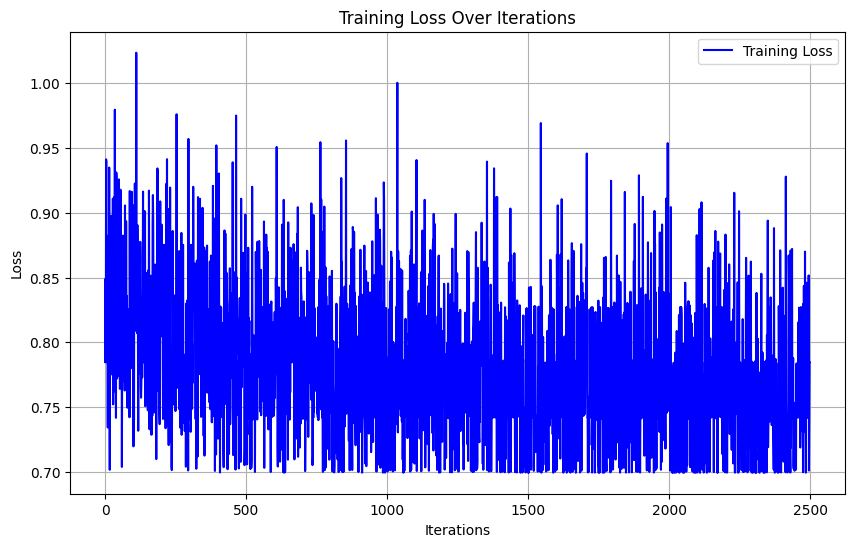

In [74]:
processor = Data_processor(config)
all_train_loader = processor(data_json,config.train_params)
model.train()
optimizer = AdamW(params, lr=config.learning_rate)
loss_list = []
true_labels, pred_labels = [], []
num_epochs=10
loss_all_list=[]
for epoch in range(num_epochs):
    model.train() 
    loss_list = []  
    count=1
    for batch in tqdm(all_train_loader, desc=f'----- [训练全部 Epoch {epoch + 1}/{num_epochs}] '):
        guids, texts, texts_mask, imgs, labels = batch
        texts, texts_mask, imgs, labels = texts.to(device), texts_mask.to(device), imgs.to(device), labels.to(device)
        pred, loss = model(texts, texts_mask, imgs, labels=labels)

        loss_list.append(loss.item())
        loss_all_list.append(loss.item())
        true_labels.extend(labels.tolist())
        pred_labels.extend(pred.tolist())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        correct_predictions = (pred == labels).sum().item()
        total_samples = labels.size(0)
        accuracy = correct_predictions / total_samples

        count += 1

    
    print("Training Accuracy:",accuracy)
    avg_train_loss = sum(loss_list) / len(loss_list)
    print(f'Epoch [{epoch + 1}/{num_epochs}], 平均训练损失: {avg_train_loss:.4f}')

save_model(config.output_path, config.fuse_model_type, model)
train_loss = round(sum(loss_list) / len(loss_list), 5)
plt.figure(figsize=(10, 6))
plt.plot(loss_all_list, label='Training Loss', color='blue')
plt.title('Training Loss Over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### 测试集预测

In [76]:
text_process('test_without_label.txt','data1','processed')
data_json1=image_process('processed', 'data1')
processor = Data_processor(config)
test_loader = processor(data_json1,config.train_params)
model.eval()

pred_guids, pred_labels = [], []

for batch in tqdm(test_loader, desc='----- [Predicting] '):
    guids, texts, texts_mask, imgs, labels = batch
    texts, texts_mask, imgs = texts.to(device), texts_mask.to(device), imgs.to(device)
    pred = model(texts, texts_mask, imgs)

    pred_guids.extend(guids)
    pred_labels.extend(pred.tolist())

outputs=[(guid,label) for guid,label in zip(pred_guids,pred_labels)]
formated_outputs = processor.decode(outputs)
with open('test_results', 'w') as f:
        for line in tqdm(formated_outputs, desc='writing in the file'):
            f.write(str(line))
            f.write('\n')
        f.close()


it is encoding!:   3%|▎         | 16/511 [00:00<00:05, 96.18it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  18%|█▊        | 91/511 [00:00<00:01, 284.54it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  34%|███▍      | 173/511 [00:00<00:01, 332.82it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  50%|████▉     | 254/511 [00:00<00:00, 367.91it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  57%|█████▋    | 292/511 [00:00<00:00, 371.41it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  74%|███████▍  | 380/511 [00:01<00:00, 390.76it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!:  92%|█████████▏| 472/511 [00:01<00:00, 407.11it/s]

here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


it is encoding!: 100%|██████████| 511/511 [00:01<00:00, 355.77it/s]


here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!
here!!!


----- [Predicting] : 100%|██████████| 32/32 [01:14<00:00,  2.33s/it]
Outputting the file: 511it [00:00, ?it/s]
writing in the file: 0it [00:00, ?it/s]
